In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

In [3]:
plt.rcParams['figure.figsize'] = (15, 8)

In [5]:
base_db = pd.read_csv("output/base_db.csv").drop(columns="Unnamed: 0")

# Repeated experiments

**Considering only the top case duration experiments**

In [11]:
base_db.obs_duration_mean.value_counts()

96.00     23807
24.00     12040
48.00      9878
72.00      2949
6.00        952
          ...  
720.00        1
79.45         1
0.35          1
123.00        1
142.00        1
Name: obs_duration_mean, Length: 272, dtype: int64

In [14]:
base_db = base_db[base_db.obs_duration_mean.isin([96, 24, 48, 72])]
base_db.index.size

48674

In [28]:
grouped_std = base_db.groupby(["obs_duration_mean", "test_cas", "species"]).std().dropna().reset_index()

In [53]:
grouped_96h = grouped_std[grouped_std.obs_duration_mean==96]
grouped_96h.conc1_mean.sort_values(ascending=False)

6831    353482.679915
5093     53103.719267
4358     27734.305472
5017     21791.676801
4513     15563.420254
            ...      
7777         0.000000
4860         0.000000
6923         0.000000
5270         0.000000
5816         0.000000
Name: conc1_mean, Length: 3638, dtype: float64

In [36]:
grouped_std.loc[6831]

obs_duration_mean             96
test_cas                 8012951
species              macrochirus
conc1_mean                353483
Name: 6831, dtype: object

In [38]:
base_db[(base_db.obs_duration_mean==96) & (base_db.test_cas==8012951) & (base_db.species=="macrochirus")]

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group
21857,8012951,S,96.0,A,500000.0,Actinopterygii,Perciformes,Centrarchidae,Lepomis,macrochirus,NC,0.34 g,"Fish,Standard Test Species"
52635,8012951,S,96.0,A,100.0,Actinopterygii,Perciformes,Centrarchidae,Lepomis,macrochirus,NC,0.46 g,"Fish,Standard Test Species"


In [ ]:
results_final= pd.read_pickle("data/results_final.pkl")

In [48]:
t = results_final[(results_final.test_cas==8012951) & (results_final.species=="macrochirus")]
t[["conc1_mean", "conc1_unit"]]

,conc1_mean,conc1_unit
25061,500000,ppm
36634,100,ppm
60143,100,ppm


In [39]:
grouped_std.loc[5093]

obs_duration_mean          96
test_cas               111466
species              promelas
conc1_mean            53103.7
Name: 5093, dtype: object

In [41]:
base_db[(base_db.obs_duration_mean==96) & (base_db.test_cas==111466) & (base_db.species=="promelas")]

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group
18579,111466,S,96.0,F,100.0,Actinopterygii,Cypriniformes,Cyprinidae,Pimephales,promelas,NR,NR,"Fish,Standard Test Species"
51119,111466,F,96.0,A,75200.0,Actinopterygii,Cypriniformes,Cyprinidae,Pimephales,promelas,NR,"19.1 MM, 0.102 G","Fish,Standard Test Species"


In [45]:
t1 = results_final[(results_final.test_cas==111466) & (results_final.species=="promelas")]
t1[["conc1_mean", "conc1_unit"]]

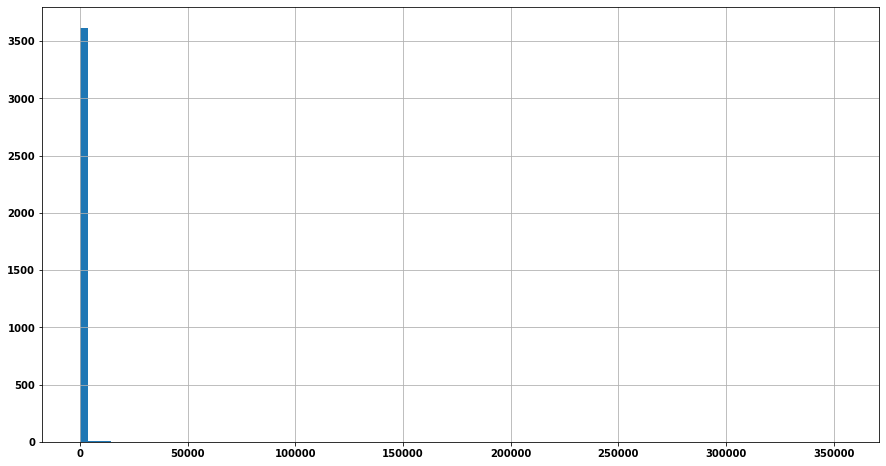

In [54]:
grouped_96h.conc1_mean.hist(bins=100)

In [69]:
grouped_96h.index.size

3638

In [68]:
grouped96h_no_out = grouped_96h[~(grouped_96h.conc1_mean>1000)]
grouped96h_no_out.index.size

3577

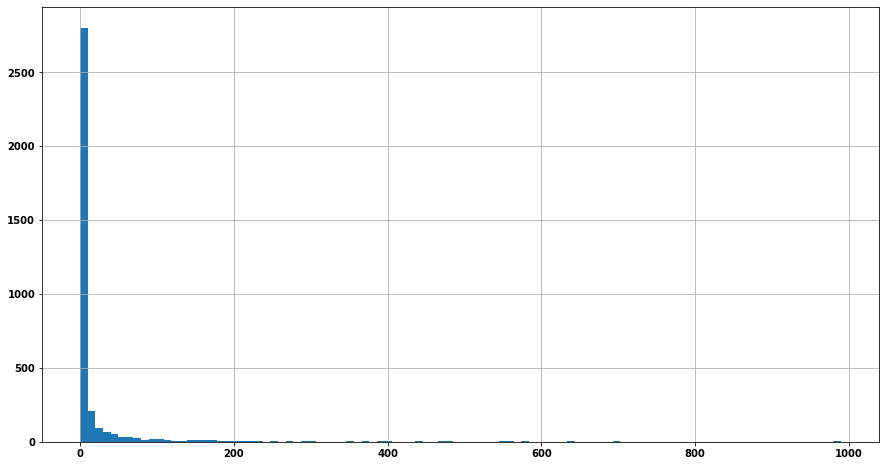

In [66]:
grouped96h_no_out.conc1_mean.hist(bins=100)

In [67]:
grouped96h_no_out[grouped96h_no_out.conc1_mean<10]

,obs_duration_mean,test_cas,species,conc1_mean
4227,96.0,50000,carolinus,2.909181
4228,96.0,50000,macrochirus,0.919239
4230,96.0,50000,promelas,1.171893
4231,96.0,50000,punctatus,0.000000
4234,96.0,50282,marmoratus,2.573869
...,...,...,...,...
7857,96.0,177256698,tshawytscha,0.000000
7858,96.0,187166401,macrochirus,0.951766
7860,96.0,243973208,promelas,0.000000
7861,96.0,243973208,variegatus,0.000000


In [70]:
grouped_24h = grouped_std[grouped_std.obs_duration_mean==24]
grouped_24h.conc1_mean.sort_values(ascending=False)

524     118952.849066
518      29965.980711
104      18738.329701
230      18027.756377
220      10487.769067
            ...      
1689         0.000000
867          0.000000
1765         0.000000
1459         0.000000
1193         0.000000
Name: conc1_mean, Length: 1891, dtype: float64

In [71]:
grouped_std.loc[524]

obs_duration_mean             24
test_cas                  108872
species              crysoleucas
conc1_mean                118953
Name: 524, dtype: object

In [72]:
base_db[(base_db.obs_duration_mean==24) & (base_db.test_cas==108872) & (base_db.species=="crysoleucas")]

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group
737,108872,S,24.0,F,238000.0,Actinopterygii,Cypriniformes,Cyprinidae,Notemigonus,crysoleucas,NR,NR,Fish
3504,108872,S,24.0,F,62.0,Actinopterygii,Cypriniformes,Cyprinidae,Notemigonus,crysoleucas,NR,NR,Fish
3530,108872,S,24.0,F,180.0,Actinopterygii,Cypriniformes,Cyprinidae,Notemigonus,crysoleucas,NR,NR,Fish
25760,108872,S,24.0,F,41.0,Actinopterygii,Cypriniformes,Cyprinidae,Notemigonus,crysoleucas,NR,NR,Fish


In [77]:
t2 = results_final[(results_final.obs_duration_mean=="24") & (results_final.test_cas==108872) & (results_final.species=="crysoleucas")]
t2[["conc1_mean", "conc1_unit"]]

,conc1_mean,conc1_unit
892,238000000*,ug/L
4098,62000*,ug/L
4125,180000*,ug/L
29491,41000*,ug/L


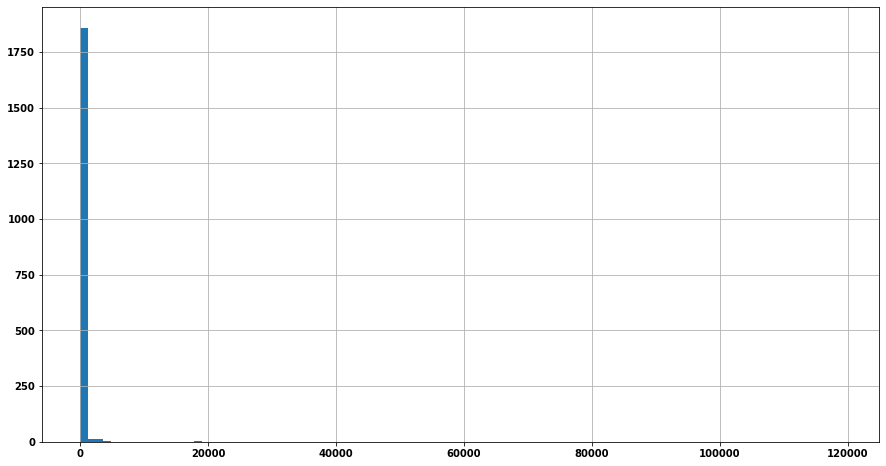

In [78]:
grouped_24h.conc1_mean.hist(bins=100)

In [80]:
grouped_24h.index.size

1891

In [83]:
grouped_24h[~(grouped_24h.conc1_mean>1000)]

,obs_duration_mean,test_cas,species,conc1_mean
0,24.0,50000,carolinus,3.579572
1,24.0,50000,latipes,27.300794
2,24.0,50000,mykiss,30.405592
3,24.0,50000,punctatus,28.867513
4,24.0,50000,saxatilis,44.353880
...,...,...,...,...
1886,24.0,96352691,mykiss,0.000000
1887,24.0,100473083,macrochirus,0.611010
1888,24.0,100473083,mykiss,0.707107
1889,24.0,107534963,rerio,12.586501
